# General-Purpose Neural Network



## Initialization

In [1]:
import os

print('Current working directory: ',os.getcwd())

Current working directory:  c:\Users\mungi\OneDrive\Desktop\Nello\VSD


In [2]:
import sys
import os
import torch
import pandas as pd
import scipy as sp
import numpy as np
from nnodely.support.initializer import *
from nnodely.support.utils import *

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from nnodely import *
from nnodely.support import earlystopping

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.1 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Current working directory:  c:\Users\mungi\OneDrive\Desktop\Nello\VSD


## Datasets

In [3]:
from scipy.interpolate import interp1d

data_folder = os.path.join(os.getcwd(),'Dataset')

####### TRAINING DATA ########
data_folder_train = os.path.join(data_folder,'Complete Dynamics/training')
training_data=pd.read_csv(os.path.join(data_folder_train,'ftg_stanley_total_training.csv'))

####### VALIDATION DATA ########
data_folder_Validation = os.path.join(data_folder,'Complete Dynamics/validation')
Validation_data=pd.read_csv(os.path.join(data_folder_Validation,'ftg_stanley_total_validation.csv'))

####### TEST DATA ########

flag=0 # flag to chosse the test dataset
# flag=0 -> fg_single_mass_processed.csv
# flag=1 -> fg_double_mass_processed.csv
# flag=2 -> Frastagliate_tot.csv
# flag=3 -> Intermedie_tot.csv
# flag=4 -> Normal_1weight_v03.csv
# flag=5 -> Normal_2weights_v025.csv

data_folder_Test= os.path.join(data_folder,'Robusteness')

if flag==0:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'single_mass.csv'))
elif flag==1:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'double_mass.csv'))
elif flag==2:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'tire_set_1.csv'))
elif flag==3:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'tire_set_2.csv'))
elif flag==4:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'Normal_1weight.csv'))
elif flag==5:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'Normal_2weights.csv'))

## GP NN Structure

In [4]:
# -----------------------------------------------
def myStack(velocity, current,steer):
    import torch
    return torch.cat((velocity, current,steer),dim=1)
# -----------------------------------------------
# Neural model inputs and outputs
# -----------------------------------------------
current         = Input('crt')       
vx           = Input('vel')            # [m/s] longitudinal velocity  
accy        = Input('accy')         # [rad] steering wheel angle
steer        = Input('steer') 
acc = Input('acc')            # [m/s^2] longitudinal acceleration
yaw_rate_input         = Input('yaw_rate') 

# Window size for the inputs
num_samples_past   = 15 # number of samples in the past for the steering wheel angle prediction
n=11

np.random.seed(1)  # Imposta il seed per rendere i risultati riproducibili
first_value = np.random.normal(0,1e-4)
bias_value = np.random.normal(0,1e-4)

fun_acc = ParamFun(myStack)(vx.sw(num_samples_past), current.sw(num_samples_past), steer.sw(num_samples_past))

# data-driven layers to estimate the effects of the engine force, by processing a past window of motor torque values
current_layer_12 = Fir(output_dimension=n,  b =True, b_init = init_negexp, b_init_params={'size_index':0, 'first_value':bias_value, 'lambda':3},
                       W_init = init_negexp, W_init_params={'size_index':0, 'first_value':first_value, 'lambda':3})(fun_acc)
current_layer_2 = Tanh(current_layer_12)
current = Linear(current_layer_2)
yaw_rate = Linear(current_layer_2)
# Create neural network output
acc_out = Output('acceleration', current)
yaw_rate_out = Output('yaw_rate_', yaw_rate)

### nnodely definitions

In [5]:
# Create a nnodely model
path_folder   = os.path.join(os.getcwd(),'trained_models','Combined_dynamics_GNN')    # folder to save the model 
GNN_dynamics   = nnodely(visualizer='Standard',seed=12,workspace=path_folder,save_history=False)  #visualizer=MPLVisulizer()

# Add the neural model to the nnodely structure and neuralization of the model
GNN_dynamics.addModel('acc',[acc_out,yaw_rate_out])
GNN_dynamics.addMinimize('acc_error', 
                                    acc.next(),  # next means the first value in the "future"
                                    acc_out, 
                                    loss_function='rmse')
GNN_dynamics.addMinimize('yaw_rate_error', 
                                    yaw_rate_input.next(),  # next means the first value in the "future"
                                    yaw_rate_out, 
                                    loss_function='rmse')

In [6]:
GNN_dynamics.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {},
 'Functions': {'FParamFun7': {'code': 'def myStack(velocity, current,steer):\n'
                                      '    import torch\n'
                                      '    return torch.cat((velocity, '
                                      'current,steer),dim=1)\n',
                              'in_dim': [{'dim': 1, 'sw': 15},
                                         {'dim': 1, 'sw': 15},
                                         {'dim': 1, 'sw': 15}],
                              'map_over_dim': False,
                              'n_input': 3,
                              'name': 'myStack',
                              'params_and_consts': []}},
 'Info': {'SampleTime': 1,
          'nnodely_version': '1.5.1',
          'ns': [15, 1],
          'ntot': 16,
          'num_parameters': 528},
 'Inputs': {'acc': {'dim': 1, 'ns': [0, 1], 'ntot': 1, 'sw': [0, 1]},
            'cr

## Training and validation datasets

In [7]:
ratio_rpm_v=4244.0 # ratio ti pass from electrical rpm to m/s
# -----------------------------------------------
from scipy.constants import g
speed_ms_train=(training_data["Speed"].values)/ratio_rpm_v
yaw_rate_train=np.deg2rad(training_data["yaw_rate"].values)
torque_train=training_data["current"].values
acc_train=training_data["accx"].values*g
delta_train=training_data["steering_angle"].values
accy_train=training_data["accy"].values*g
perc=0.6
size_train= round(len(delta_train)*perc)
dataset_training = {'vel': speed_ms_train[:size_train], 'crt': torque_train[:size_train], 'acc' : acc_train[:size_train], 'steer' : delta_train[:size_train] , 'accy' : accy_train[:size_train], 'yaw_rate' : yaw_rate_train[:size_train]}

speed_ms_validation=(Validation_data["Speed"].values)/ratio_rpm_v
yaw_rate_validation=np.deg2rad(Validation_data["yaw_rate"].values)
torque_validation=Validation_data["current"].values
acc_validation=Validation_data["accx"].values*g
delta_validation=Validation_data["steering_angle"].values
accy_validation=Validation_data["accy"].values*g
dataset_validation = {'vel': speed_ms_validation, 'crt': torque_validation, 'acc' : acc_validation, 'steer' : delta_validation, 'accy' : accy_validation, 'yaw_rate' : yaw_rate_validation}

yaw_rate_test=np.deg2rad(Test_data["yaw_rate"].values)
speed_ms_test=(Test_data["Speed"].values)/ratio_rpm_v
torque_test=Test_data["current"].values
acc_test=Test_data["accx"].values*g
accy_test=Test_data["accy"].values*g
delta_test=Test_data["steering_angle"].values
dataset_test = {'vel': speed_ms_test, 'crt': torque_test, 'acc' : acc_test, 'steer' : delta_test , 'accy' : accy_test, 'yaw_rate' : yaw_rate_test}

# Pass the training and the validation datasets to the nnodely structure

GNN_dynamics.loadData(name='training_set', source=dataset_training)
GNN_dynamics.loadData(name='validation_set', source=dataset_validation)
GNN_dynamics.loadData(name='Test_set', source=dataset_test)




============================ nnodely Model Dataset =============================
Dataset Name:                 training_set
Number of files:              1
Total number of samples:      1504
Shape of steer:               (1504, 15, 1)
Shape of crt:                 (1504, 15, 1)
Shape of vel:                 (1504, 15, 1)
Shape of yaw_rate:            (1504, 1, 1)
Shape of acc:                 (1504, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              1
Total number of samples:      1182
Shape of steer:               (1182, 15, 1)
Shape of crt:                 (1182, 15, 1)
Shape of vel:                 (1182, 15, 1)
Shape of yaw_rate:            (1182, 1, 1)
Shape of acc:                 (1182, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 Test_set
Number of files:              1
Total number of samples:    

## Training

In [ ]:
num_epochs = 1000
batch_size = 100
learn_rate = 1e-3 
early_stop_patience = 500
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}

flag_train_now = 1
if flag_train_now:
  train_result_open_loop = GNN_dynamics.trainAndAnalyze(train_dataset='training_set', validation_dataset='validation_set', test_dataset='Test_set', 
                                                              training_params=training_pars, optimizer='Adam', shuffle_data=False,
                                                              early_stopping=earlystopping.early_stop_patience,  
                                                              early_stopping_params={'patience':early_stop_patience,
                                                                                    'error':'acc_error','error':'yaw_rate_error'}) 
  GNN_dynamics.saveModel() 
else:
  # Load the trained model
  GNN_dynamics.loadModel() 
  GNN_dynamics.neuralizeModel() 

======================== nnodely Model Train Parameters ========================
models:                       ['acc']
num of epochs:                30000
update per epochs:            15
└>(n_samples-batch_size)/batch_size+1
early stopping:               early_stop_patience
early stopping params:        {'error': 'yaw_rate_error', 'patience': 500}
train dataset:                training_set
	- batch size:                100
	- num of samples:            1504
validation dataset:           validation_set
	- batch size:                100
	- num of samples:            1182
minimizers:                   {'acc_error': {'A': 'SamplePart12',
                                             'B': 'Linear9',
                                             'loss': 'rmse'},
                               'yaw_rate_error': {'A': 'SamplePart14',
                                                  'B': 'Linear10',
                                                  'loss': 'rmse'}}
optimizer:                   

## Fine Tuning

In [10]:
num_epochs = 60
batch_size = 100 # 100
learn_rate = 1e-3 # learning rate e-5
early_stop_patience = 30 
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}

flag_train_now_fine_tuning = 0
if flag_train_now_fine_tuning:
  train_result_open_loop = GNN_dynamics.trainModel(train_dataset='Test_set',  validation_dataset= 'training_set', # test_dataset= 'Test_set',
                                                              training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                              early_stopping=earlystopping.early_stop_patience,  
                                                              early_stopping_params={'patience':early_stop_patience,
                                                                                    'error':'acc_error','error':'yaw_rate_error'}) 
else:
  # Load the trained model
  GNN_dynamics.loadModel() 

=============================== Load JSON Model ================================
Model loaded from:            c:\Users\mungi\OneDrive\Desktop\Nello\VSD\trained_models\Combined_dynamics_GNN\net.json


In [11]:
# Print the trained NN parameters
GNN_dynamics.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {},
 'Functions': {'FParamFun7': {'code': 'def myStack(velocity, current,steer):\n'
                                      '    import torch\n'
                                      '    return torch.cat((velocity, '
                                      'current,steer),dim=1)\n',
                              'in_dim': [{'dim': 1, 'sw': 15},
                                         {'dim': 1, 'sw': 15},
                                         {'dim': 1, 'sw': 15}],
                              'map_over_dim': False,
                              'n_input': 3,
                              'name': 'myStack',
                              'params_and_consts': []}},
 'Info': {'SampleTime': 1,
          'nnodely_version': '1.5.1',
          'ns': [15, 1],
          'ntot': 16,
          'num_parameters': 528},
 'Inputs': {'acc': {'dim': 1, 'ns': [0, 1], 'ntot': 1, 'sw': [0, 1]},
            'cr

## Results

RMSE on the test set:  [0.87469074]  rad^2


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

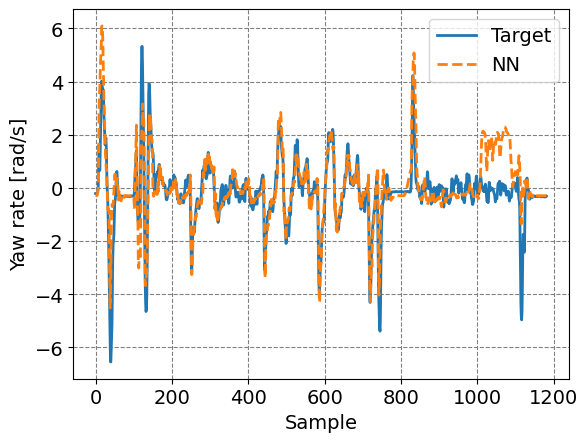

c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

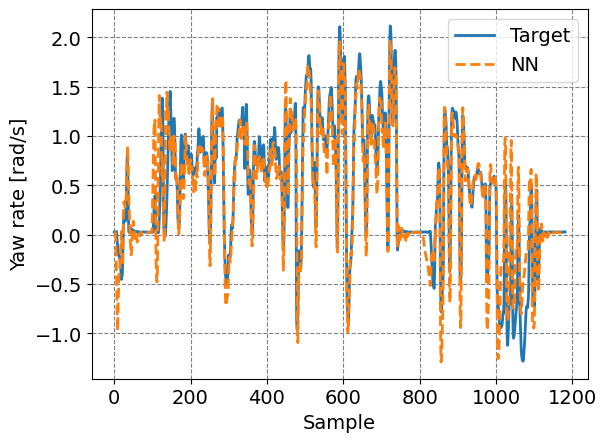

In [ ]:
# Test on a new dataset
num_samples_use  = np.size(acc_validation)-num_samples_past
samples_Validation_set = GNN_dynamics.getSamples('validation_set', index=0, window=num_samples_use) 
out_nn_test_set  = GNN_dynamics(samples_Validation_set, sampled=True)
out_nn_Validation_set_extract = np.asarray(out_nn_test_set['acceleration'])
out_nn_Validation_set_extract2 = np.asarray(out_nn_test_set['yaw_rate_'])

# Extract the samples
samples_Validation_set_extract = np.zeros((len(samples_Validation_set['acc']),1))
for i in range(0,len(samples_Validation_set_extract)):
  samples_Validation_set_extract[i] = samples_Validation_set['acc'][i]

# Extract the samples
samples_Validation_set_extract2 = np.zeros((len(samples_Validation_set['yaw_rate']),1))
for i in range(0,len(samples_Validation_set_extract2)):
  samples_Validation_set_extract2[i] = samples_Validation_set['yaw_rate'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_Validation_set_extract)):
  mse_calc = mse_calc + (samples_Validation_set_extract[i] - out_nn_Validation_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_Validation_set_extract))
print('RMSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot((samples_Validation_set_extract
            ),label='Target',linewidth=2)
  plt.plot((out_nn_Validation_set_extract
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()
  plt.figure()
  plt.plot((samples_Validation_set_extract2
            ),label='Target',linewidth=2)
  plt.plot((out_nn_Validation_set_extract2
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()

RMSE on the test set:  [0.3258454]  rad^2


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

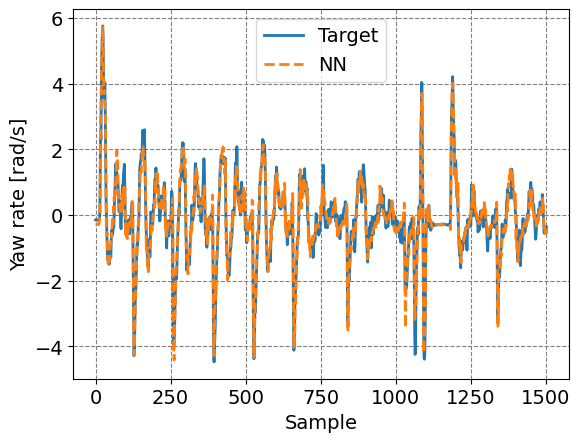

c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

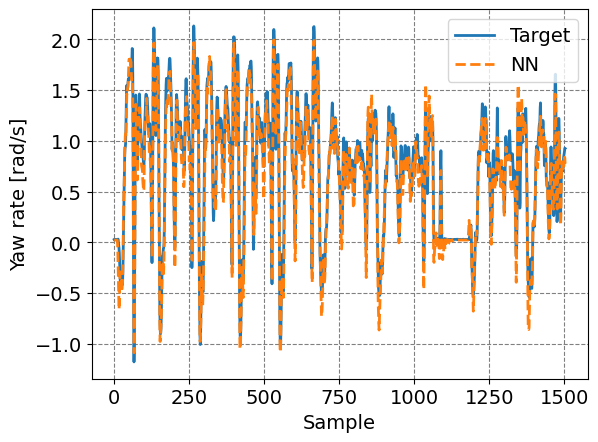

In [13]:
# Test on a new dataset
num_samples_use  = size_train-num_samples_past
samples_training_set = GNN_dynamics.getSamples('training_set', index=0, window=num_samples_use) 
out_nn_training_set  = GNN_dynamics(samples_training_set, sampled=True)
out_nn_training_set_extract = np.asarray(out_nn_training_set['acceleration'])
out_nn_training_set_extract2 = np.asarray(out_nn_training_set['yaw_rate_'])

# Extract the samples
samples_training_set_extract = np.zeros((len(samples_training_set['acc']),1))
for i in range(0,len(samples_training_set_extract)):
  samples_training_set_extract[i] = samples_training_set['acc'][i]

# Extract the samples
samples_training_set_extract2 = np.zeros((len(samples_training_set['yaw_rate']),1))
for i in range(0,len(samples_training_set_extract2)):
  samples_training_set_extract2[i] = samples_training_set['yaw_rate'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_training_set_extract)):
  mse_calc = mse_calc + (samples_training_set_extract[i] - out_nn_training_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_training_set_extract))
print('RMSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot((samples_training_set_extract
            ),label='Target',linewidth=2)
  plt.plot((out_nn_training_set_extract
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure()
  plt.plot((samples_training_set_extract2
            ),label='Target',linewidth=2)
  plt.plot((out_nn_training_set_extract2
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()


RMSE on the test set:  [0.46200121]  rad^2


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

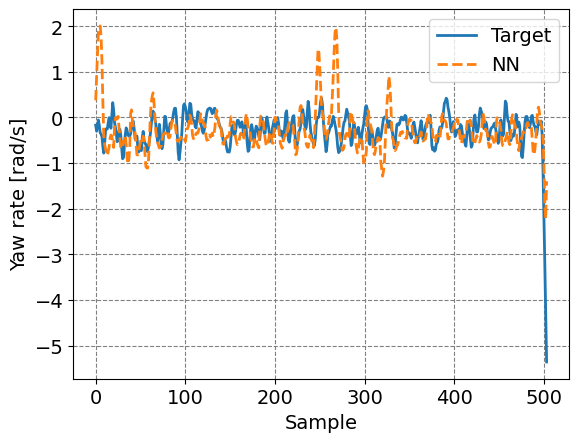

c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

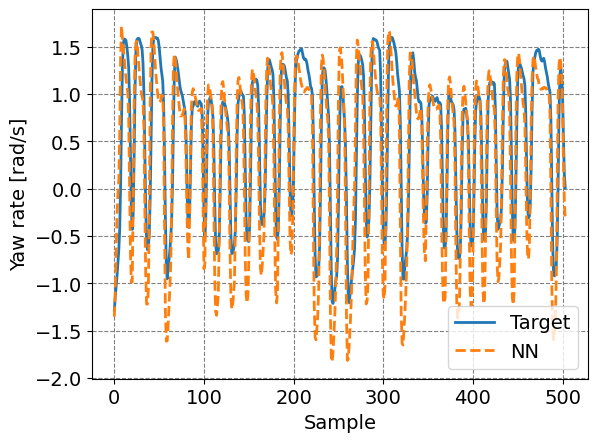

In [14]:
num_samples_use  = np.size(acc_test)-num_samples_past
samples_test_set = GNN_dynamics.getSamples('Test_set', index=0, window=num_samples_use) 
out_nn_test_set  = GNN_dynamics(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['acceleration'])
out_nn_test_set_extract2 = np.asarray(out_nn_test_set['yaw_rate_'])


# Extract the samples
samples_test_set_extract2 = np.zeros((len(samples_test_set['yaw_rate']),1))
for i in range(0,len(samples_test_set_extract2)):
  samples_test_set_extract2[i] = samples_test_set['yaw_rate'][i]

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['acc']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['acc'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract2)):
  mse_calc = mse_calc + (samples_test_set_extract2[i] - out_nn_test_set_extract2[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_test_set_extract2))
print('RMSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot((samples_test_set_extract
            ),label='Target',linewidth=2)
  plt.plot((out_nn_test_set_extract
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()
  
  plt.figure()
  plt.plot((samples_test_set_extract2
            ),label='Target',linewidth=2)
  plt.plot((out_nn_test_set_extract2
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()